In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from Data_handler import Data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os

# 2 Loading the data

In [92]:
# Prepare data
Data_instance = Data()               # create instance of the class Data()
data = Data_instance.get_data()      # store the data of Data_instance

Data has been loaded from local files. Only data with more than 36 observations has been kept.


In [93]:
display(data)

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746
...,...,...,...,...,...,...,...,...
1439403,90996,2008-03-31,0.008584,48790.0,2.35000,2834,0.001032,-0.010444
1439404,90996,2008-02-29,-0.127341,48585.0,2.33000,2834,0.001727,-0.021697
1439405,90996,2008-01-31,-0.178462,48585.0,2.67000,2834,0.001388,-0.062218
1439406,90996,2007-12-31,0.199262,48585.0,3.25000,2834,0.002384,-0.004405


# 3 Betting Against Beta

## Question a)

In [94]:
# Overview of the data
display(data.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,5094,0.002932,-0.019258
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,5094,0.003034,0.006407
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,5094,0.002924,0.013414
3,10028,1992-03-31,0.419355,5548.0,2.75000,5094,0.003348,-0.023699
4,10028,1998-05-29,0.047619,4151.0,2.75000,5094,0.003813,-0.025746


In [95]:
data = Data_instance.get_rolling_beta().copy().dropna() # Get the rolling betas from the data. This is a method from the class Data, in Data_handler.py
display(data)

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta
34,10028,1995-11-30,-0.052632,5873.0,-1.1250,5094,0.004525,0.042771,0.038246,-0.057157,0.888358
37,10028,1995-08-31,0.000000,5883.0,1.3750,5094,0.004483,0.009300,0.004817,-0.004483,0.988659
39,10028,1995-06-30,-0.166667,5883.0,-1.5625,5094,0.004448,0.031142,0.026694,-0.171115,1.004189
43,10028,1995-02-28,0.071429,5834.0,-1.8750,5094,0.004191,0.039647,0.035456,0.067238,1.010094
45,10028,1994-12-30,-0.052632,5834.0,-2.2500,5094,0.003954,0.012580,0.008626,-0.056586,1.139478
...,...,...,...,...,...,...,...,...,...,...,...
1402310,90994,2006-06-30,-0.185730,152685.0,7.1900,1221,0.003911,-0.000391,-0.004302,-0.189641,0.536882
1402314,90994,2006-02-28,-0.155138,152322.0,8.5500,1221,0.003693,-0.001639,-0.005332,-0.158831,0.532904
1402316,90994,2005-12-30,-0.136364,152322.0,9.5000,1221,0.003294,0.003458,0.000164,-0.139658,0.516774
1402354,90996,2008-02-29,-0.127341,48585.0,2.3300,2834,0.001727,-0.021697,-0.023424,-0.129068,0.419406


In [96]:
data_Qb = data.copy().dropna()
print("Initial number of observations: ", data.shape[0])
print("Final number of observations: \t", data_Qb.shape[0])

Initial number of observations:  412258
Final number of observations: 	 412258


## Question b)

### Equally weighted portfolios

In [97]:
# Create deciles based on Beta value
data_Qb["EW_monthly_decile"] = data_Qb.groupby("date")["beta"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute monthly return per decile group
data_Qb["EW_monthly_return"] = data_Qb.groupby(["date", "EW_monthly_decile"])["ret"].transform("mean")

display(data_Qb)#.sample(5)) # to get an overview of the dataframe

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,EW_monthly_decile,EW_monthly_return
34,10028,1995-11-30,-0.052632,5873.0,-1.1250,5094,0.004525,0.042771,0.038246,-0.057157,0.888358,3,0.039534
37,10028,1995-08-31,0.000000,5883.0,1.3750,5094,0.004483,0.009300,0.004817,-0.004483,0.988659,4,0.002707
39,10028,1995-06-30,-0.166667,5883.0,-1.5625,5094,0.004448,0.031142,0.026694,-0.171115,1.004189,4,0.041171
43,10028,1995-02-28,0.071429,5834.0,-1.8750,5094,0.004191,0.039647,0.035456,0.067238,1.010094,4,0.044496
45,10028,1994-12-30,-0.052632,5834.0,-2.2500,5094,0.003954,0.012580,0.008626,-0.056586,1.139478,5,0.017551
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402310,90994,2006-06-30,-0.185730,152685.0,7.1900,1221,0.003911,-0.000391,-0.004302,-0.189641,0.536882,1,-0.023012
1402314,90994,2006-02-28,-0.155138,152322.0,8.5500,1221,0.003693,-0.001639,-0.005332,-0.158831,0.532904,1,-0.003778
1402316,90994,2005-12-30,-0.136364,152322.0,9.5000,1221,0.003294,0.003458,0.000164,-0.139658,0.516774,1,-0.001349
1402354,90996,2008-02-29,-0.127341,48585.0,2.3300,2834,0.001727,-0.021697,-0.023424,-0.129068,0.419406,0,-0.039145


### Value weighted portfolios

In [98]:
# Add company market capitalization
data_Qb['MktCap'] = np.abs(data_Qb.prc) * data_Qb.shrout

# Create monthly deciles based MktCap
data_Qb["VW_monthly_decile"] = data_Qb["EW_monthly_decile"] #data_Qb.groupby("date")["MktCap"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute the total market capitaliztion for each decile, each month
data_Qb["MktCap_sum"] = data_Qb.groupby(["date", "VW_monthly_decile"])["MktCap"].transform("sum")

# Create weight of the stock to the decile portofolio, for each month
data_Qb["VW_monthly_weight"] = data_Qb["MktCap"] / data_Qb["MktCap_sum"]

# Compute each stock's monthly return in the VW portoflio, for each month, decile
data_Qb["VW_monthly_return"] = data_Qb["ret"] * data_Qb["VW_monthly_weight"]

# Clean the dataframe and delete useless columns: VW_monthly_weight, MktCap_sum
data_Qb = data_Qb.drop(columns=["MktCap_sum"])

display(data_Qb.head(5)) # to get an overview of the dataframe

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,EW_monthly_decile,EW_monthly_return,MktCap,VW_monthly_decile,VW_monthly_weight,VW_monthly_return
34,10028,1995-11-30,-0.052632,5873.0,-1.1250,5094,0.004525,0.042771,0.038246,-0.057157,0.888358,3,0.039534,6607.1250,3,0.000012,-6.310358e-07
37,10028,1995-08-31,0.000000,5883.0,1.3750,5094,0.004483,0.009300,0.004817,-0.004483,0.988659,4,0.002707,8089.1250,4,0.000023,0.000000e+00
39,10028,1995-06-30,-0.166667,5883.0,-1.5625,5094,0.004448,0.031142,0.026694,-0.171115,1.004189,4,0.041171,9192.1875,4,0.000020,-3.276436e-06
43,10028,1995-02-28,0.071429,5834.0,-1.8750,5094,0.004191,0.039647,0.035456,0.067238,1.010094,4,0.044496,10938.7500,4,0.000015,1.091091e-06
45,10028,1994-12-30,-0.052632,5834.0,-2.2500,5094,0.003954,0.012580,0.008626,-0.056586,1.139478,5,0.017551,13126.5000,5,0.000035,-1.863627e-06


### Auxiliary functions for plots

In [99]:
def plot_from_lists(mean, std, sharpe, plot_color = 'blue'):
    deciles = list(range(len(mean)))

    _, axs = plt.subplots(1, 3, figsize=(25, 7), sharey=False)

    axs[0].bar(deciles, mean, color=plot_color)
    axs[0].set_title("Average portolio mean return")
    axs[0].set_xticks(deciles)
    axs[0].set_xlabel("Decile")
    axs[0].set_ylabel("Annualized return")

    axs[1].bar(deciles, std, color=plot_color)
    axs[1].set_title("Average portolio annualized standard deviation")
    axs[1].set_xticks(deciles)
    axs[1].set_xlabel("Decile")
    axs[1].set_ylabel("Annualized standard deviation")

    axs[2].bar(deciles, sharpe, color=plot_color)
    axs[2].set_title("Average portolio annualized sharpe ratio")
    axs[2].set_xticks(deciles)
    axs[2].set_xlabel("Decile")
    axs[2].set_ylabel("Annualized sharpe ratio")
    
    return plt

In [100]:
def get_mean_std_sr_EW(data, decile_col_name, decile_return_col_name):

    deciles = list(data[decile_col_name].unique())
    deciles.sort()

    MEAN, STD, SR = [], [], []

    for decile in deciles:
        d = data[data[decile_col_name] == decile]#.head(2)
        rf = d["tmytm"].mean() * 12
        mean = d[decile_return_col_name].mean() * 12
        std = d[decile_return_col_name].std() * np.sqrt(12)
        sr = (mean - rf) / std
        MEAN.append(mean)
        STD.append(std)
        SR.append(sr)
    
    return MEAN, STD, SR

def get_mean_std_sr_VW(data, decile_col_name, decile_return_col_name):

    deciles = list(data[decile_col_name].unique())
    deciles.sort()

    MEAN, STD, SR = [], [], []

    ret_vw = data.groupby(['date', decile_col_name])[decile_return_col_name].sum().reset_index()
    
    MEAN = ret_vw.groupby(decile_col_name)[decile_return_col_name].mean() * 12
    STD =  ret_vw.groupby(decile_col_name)[decile_return_col_name].std() * np.sqrt(12)

    for decile in deciles:
        d = data[data[decile_col_name] == decile]
        rf = d["tmytm"].mean() * 12
        mean = MEAN[decile]
        std = STD[decile]
        sr = (mean - rf) / std
        SR.append(sr)
    
    return MEAN, STD, SR

# def plot_mean_std_sr(data, EW = False, VW = False, decile_col='' question = None, plot_name = None, show=True):

#     if not os.path.exists("Figures"):
#             os.makedirs("Figures")

#     if EW and VW:
#         raise ValueError("You cannot specify both 'EW=True' and 'VW=True'.")
#     elif EW:
#         mean, std, sharpe = get_mean_std_sr_EW(data, 'EW_monthly_decile', 'EW_monthly_return')
#         plot = plot_from_lists(mean, std, sharpe, plot_color = 'blue')
#         plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
#         plot.savefig(f"Figures/question_{question}_plot_{plot_name}")
#         if show: 
#             plot.show()
#     elif VW:
#         mean, std, sharpe = get_mean_std_sr_VW(data_Qb, 'VW_monthly_decile', 'VW_monthly_return')
#         plot = plot_from_lists(mean, std, sharpe, plot_color = 'blue')
#         plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
#         plot.savefig(f"Figures/question_{question}_plot_{plot_name}")
#         if show: 
#             plot.show()
#     else:
#         raise ValueError("You need to specify either 'EW=True' or 'VW=True'.")
    

def plot_mean_std_sr(data, EW = False, VW = False, EW_decile_col='EW_monthly_decile', EW_return_col = 'EW_monthly_return', VW_decile_col='VW_monthly_decile', VW_return_col = 'VW_monthly_return', question = None, plot_name = None, show=True):

    if not os.path.exists("Figures"):
            os.makedirs("Figures")

    if EW and VW:
        raise ValueError("You cannot specify both 'EW=True' and 'VW=True'.")
    
    elif EW:
        mean, std, sharpe = get_mean_std_sr_EW(data, EW_decile_col, EW_return_col)
        plot = plot_from_lists(mean, std, sharpe, plot_color = 'blue')
        plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
        plot.savefig(f"Figures/question_{question}_plot_{plot_name}")
        if show: 
            plot.show()
    
    elif VW:
        mean, std, sharpe = get_mean_std_sr_VW(data_Qb, VW_decile_col, VW_return_col)
        plot = plot_from_lists(mean, std, sharpe, plot_color = 'blue')
        plot.suptitle(f'Average portolio annualized mean return, standard deviation and sharpe ratio ({plot_name})')
        plot.savefig(f"Figures/question_{question}_plot_{plot_name}")
        if show: 
            plot.show()
    
    else:
        raise ValueError("You need to specify either 'EW=True' or 'VW=True'.")

### Plot the mean returns, volatility, and sharpe ratios for EW and VW portfolios

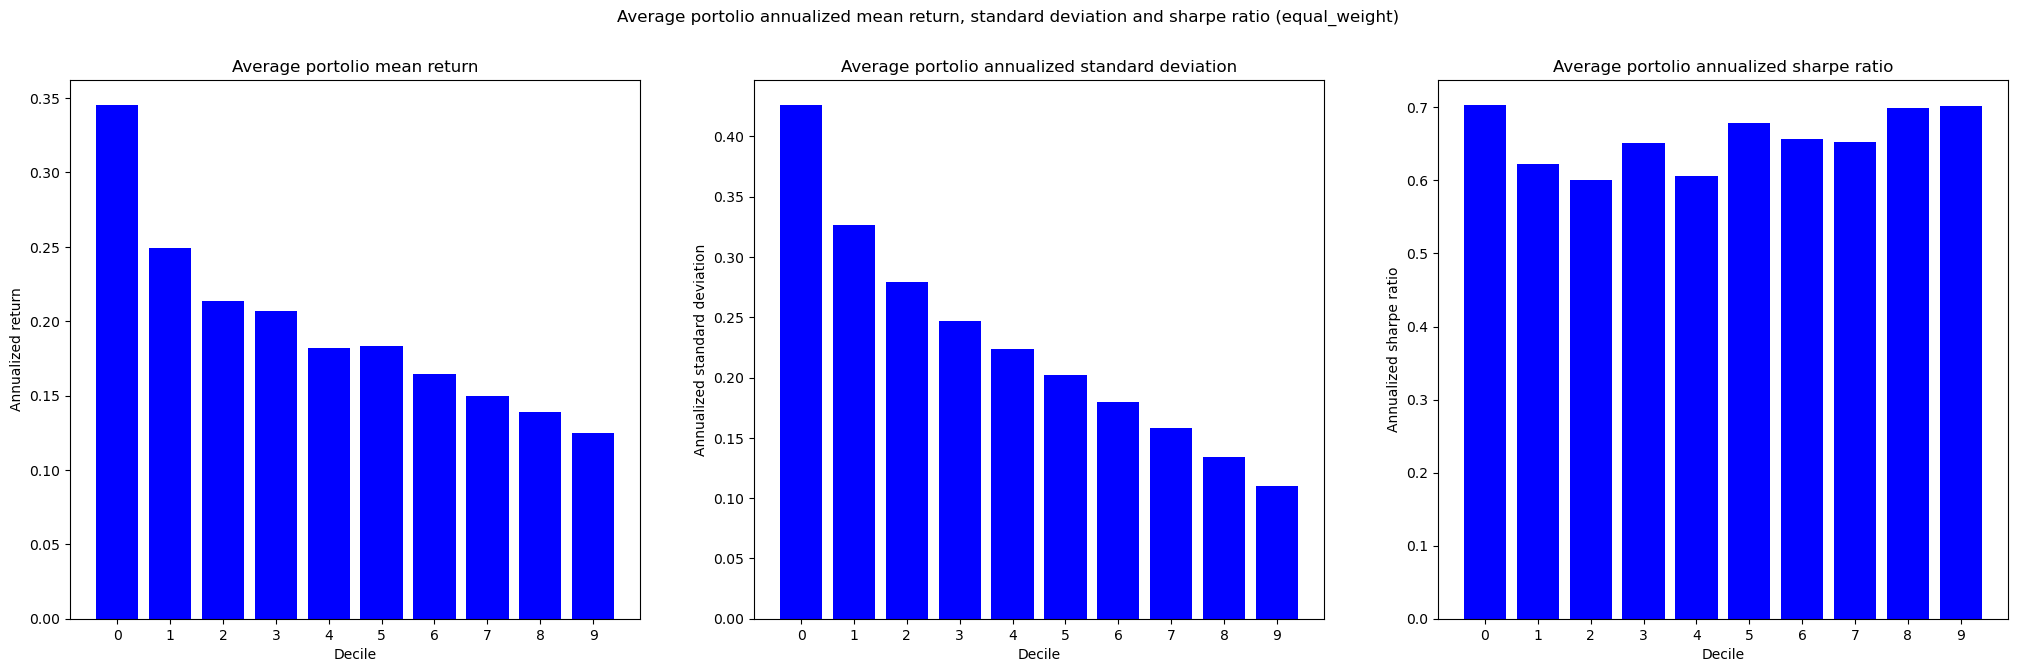

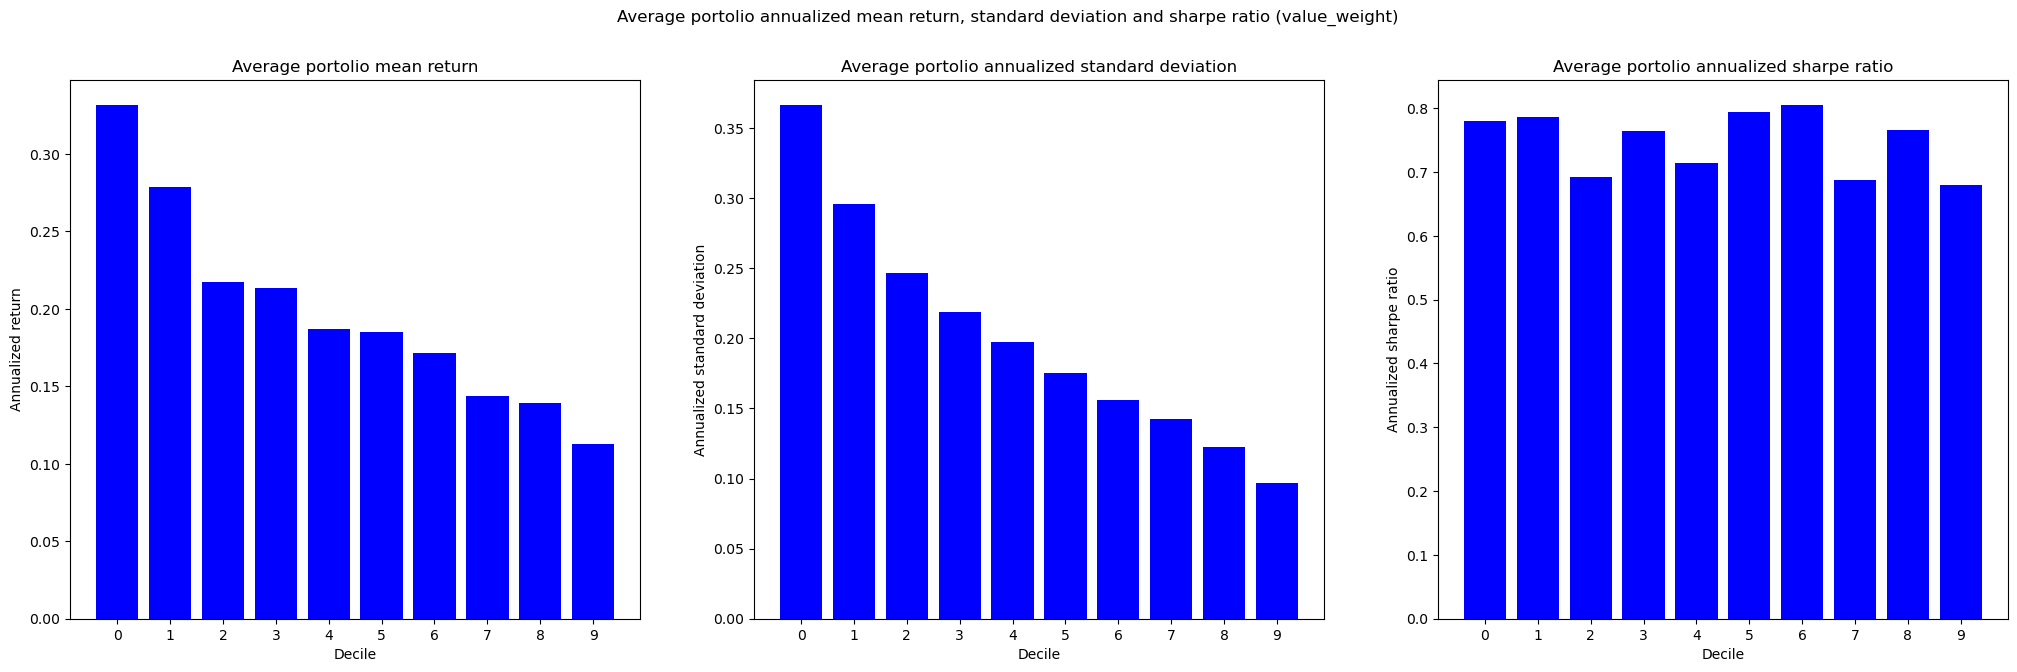

In [101]:
plot_mean_std_sr(
    data=data_Qb,
    EW = True, 
    EW_decile_col='EW_monthly_decile',
    EW_return_col='EW_monthly_return',
    VW = False, 
    question = '3b',
    plot_name= 'equal_weight', 
    show = True
)

plot_mean_std_sr(
    data=data_Qb,
    EW = False, 
    VW = True,
    VW_decile_col='VW_monthly_decile',
    VW_return_col='VW_monthly_return',
    question = '3b',
    plot_name= 'value_weight', 
    show = True
)

## Question c) and d)

### Prepare data for BAB

In [13]:
data_bab = Data_instance.get_rolling_beta().copy().dropna() # Create a separate dataset for the BAB question
data_bab.head()

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta
34,10028,1995-11-30,-0.052632,5873.0,-1.1250,5094,0.004525,0.042771,0.038246,-0.057157,0.888358
37,10028,1995-08-31,0.000000,5883.0,1.3750,5094,0.004483,0.009300,0.004817,-0.004483,0.988659
39,10028,1995-06-30,-0.166667,5883.0,-1.5625,5094,0.004448,0.031142,0.026694,-0.171115,1.004189
43,10028,1995-02-28,0.071429,5834.0,-1.8750,5094,0.004191,0.039647,0.035456,0.067238,1.010094
45,10028,1994-12-30,-0.052632,5834.0,-2.2500,5094,0.003954,0.012580,0.008626,-0.056586,1.139478


### Built the function for determining BAB weights

In [14]:
def get_bab_weights(data):
    """Computes the weights of the Betting-Against-Beta portfolio."""
    df = data.copy()
    df['z'] = df.groupby('date')['beta'].rank()                     # Assign each beta a rank, for each month
    df['z_mean'] = df.groupby('date')['z'].transform('mean')        # Calculate the monthly mean the rank
    df['norm'] = np.abs(df['z']- df['z_mean'])                      # Compute abs distance of rank to mean rank
    df['sum_norm'] = df.groupby('date')['norm'].transform("sum")    # Sum the distance
    df['k'] = 2 / df['sum_norm']                                    # Compute the k

    # Compute the BAB weights
    df['wH'] = df['k'] * np.maximum(0, df['z'] - df['z_mean'])      
    df['wL'] = df['k'] * np.minimum(0, df['z'] - df['z_mean'])

    # Drop irrelevant columns
    df = df.drop(columns=["z_mean", 'z', 'norm', 'sum_norm', 'k'])

    # Compute the weighted betas
    df['bH'] = df['wH'] * df['beta']
    df['bL'] = df['wL'] * df['beta']

    # Compute the individual returns of the portfolios H and L
    df['rH'] = df['wH'] * df['ret']
    df['rL'] = df['wL'] * df['ret']

    # Compute the individual excess returns of the portfolios H and L
    # df['rHe'] = df['rH'] - df['tmytm']
    # df['rLe'] = df['rL'] - df['tmytm']

    # Compute the return and betas of the two portfolios for each period
    df_ = df.groupby('date')[['rH', 'rL', 'bH', 'bL']].sum().reset_index()                # Get the value for each period
    df_rf = df.groupby('date')[['date', 'tmytm', 'Rm_e']].first()[['tmytm','Rm_e']]       # Dataframe for the risk free rate
    df_ = pd.merge(df_, df_rf, on = 'date')                                               # Merge the risk-free rate

    # Finally create the BAB portfolio return
    df_['rBAB'] = (df_['rL'] - df_['tmytm']) / df_['bL'] - (df_['rH'] - df_['tmytm']) / df_['bH']

    return df_

In [15]:
# Create the weights rBAB
data_BAB = get_bab_weights(data_bab)
display(data_BAB)

,date,rH,rL,bH,bL,tmytm,Rm_e,rBAB
0,1964-04-30,0.007463,0.010478,1.667298,-0.501657,0.002801,0.001806,-0.018101
1,1964-08-31,0.004809,0.016205,1.642998,-0.498138,0.002724,-0.013990,-0.028332
2,1964-09-30,0.025464,-0.049743,1.660123,-0.496657,0.002941,0.027539,0.092508
3,1964-10-30,0.012172,-0.021280,1.645884,-0.496355,0.002860,0.006009,0.042977
4,1964-11-30,0.011476,0.013595,1.624228,-0.491623,0.002983,0.000107,-0.026815
...,...,...,...,...,...,...,...,...
256,2022-12-30,-0.025005,0.074616,1.892106,-0.544022,0.003332,-0.060452,-0.116055
257,2023-02-28,-0.014215,0.028021,1.902532,-0.539368,0.003689,-0.028355,-0.035702
258,2023-06-30,0.054100,-0.122487,1.848675,-0.538885,0.004311,0.061872,0.208365
259,2023-08-31,-0.022535,0.050269,1.873971,-0.544682,0.004473,-0.025078,-0.069665


### Get the return, std and sharpe ratio of the BAB strategy

In [16]:
BAB_ret = data_BAB.rBAB.mean() * 12
BAB_std = data_BAB.rBAB.std() * np.sqrt(12)
BAB_rfr = data_BAB.tmytm.mean() * 12
BAB_shr = (BAB_ret - BAB_rfr) / BAB_std

# Compute the CAPM alpha
data_BAB['one'] = 1 # Create the column for the constant
model = sm.OLS(data_BAB['rBAB'], data_BAB[['one', 'Rm_e']]).fit() # Fit CAPM

print("Betting-against-beta strategy")
print(" - Mean return: {:.2f}%".format(BAB_ret * 100))
print(" - Standard deviation: {:.2f}%".format(BAB_std * 100))
print(" - Sharpe ratio: {:.2f}".format(BAB_shr))
print(" - CAPM alpha: {:.2f}".format(model.params.iloc[0] * 12))


Betting-against-beta strategy
 - Mean return: 51.60%
 - Standard deviation: 52.79%
 - Sharpe ratio: 0.90
 - CAPM alpha: 0.31


# 4 Momentum Strategy

## Question a)

### Create the deciles based on the 12-month cumulative return, excluding short term reversal

In [64]:
display(data.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta
34,10028,1995-11-30,-0.052632,5873.0,-1.1250,5094,0.004525,0.042771,0.038246,-0.057157,0.888358
37,10028,1995-08-31,0.000000,5883.0,1.3750,5094,0.004483,0.009300,0.004817,-0.004483,0.988659
39,10028,1995-06-30,-0.166667,5883.0,-1.5625,5094,0.004448,0.031142,0.026694,-0.171115,1.004189
43,10028,1995-02-28,0.071429,5834.0,-1.8750,5094,0.004191,0.039647,0.035456,0.067238,1.010094
45,10028,1994-12-30,-0.052632,5834.0,-2.2500,5094,0.003954,0.012580,0.008626,-0.056586,1.139478


In [65]:
data.sort_values(by=['permno', 'date'], inplace=True)
display(data.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta
186,10001,2010-09-30,0.076560,6073.0,11.12,4925,0.000112,0.091628,0.091516,0.076448,3.174904
182,10001,2011-01-31,0.028992,7834.0,10.78,4925,0.000125,0.019183,0.019058,0.028867,3.174904
181,10001,2011-02-28,0.022727,7834.0,10.98,4925,0.000065,0.038156,0.038091,0.022662,3.174904
177,10001,2011-06-30,0.008261,8151.0,11.55,4925,0.000006,-0.018447,-0.018453,0.008255,0.419406
174,10001,2011-09-30,0.005009,8152.0,10.99,4925,0.000013,-0.084983,-0.084996,0.004996,0.419406


In [66]:
# Sort data by permno, then date
data_mom = data.copy()
data_mom.sort_values(by=['permno', 'date'], inplace=True)

# Add a column for momentum return (last 12months, excluding last month)
data_mom['roll_ret'] = data_mom.groupby('permno').ret.transform(lambda x: x.rolling(11, closed='left').sum())
display(data_mom.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,roll_ret
186,10001,2010-09-30,0.076560,6073.0,11.12,4925,0.000112,0.091628,0.091516,0.076448,3.174904,NaN
182,10001,2011-01-31,0.028992,7834.0,10.78,4925,0.000125,0.019183,0.019058,0.028867,3.174904,NaN
181,10001,2011-02-28,0.022727,7834.0,10.98,4925,0.000065,0.038156,0.038091,0.022662,3.174904,NaN
177,10001,2011-06-30,0.008261,8151.0,11.55,4925,0.000006,-0.018447,-0.018453,0.008255,0.419406,NaN
174,10001,2011-09-30,0.005009,8152.0,10.99,4925,0.000013,-0.084983,-0.084996,0.004996,0.419406,NaN


In [67]:
# Create deciles for the momentum returns
data_mom['decile_mom'] = data_mom.groupby('date')['roll_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
display(data_mom.head())

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,roll_ret,decile_mom
186,10001,2010-09-30,0.076560,6073.0,11.12,4925,0.000112,0.091628,0.091516,0.076448,3.174904,NaN,NaN
182,10001,2011-01-31,0.028992,7834.0,10.78,4925,0.000125,0.019183,0.019058,0.028867,3.174904,NaN,NaN
181,10001,2011-02-28,0.022727,7834.0,10.98,4925,0.000065,0.038156,0.038091,0.022662,3.174904,NaN,NaN
177,10001,2011-06-30,0.008261,8151.0,11.55,4925,0.000006,-0.018447,-0.018453,0.008255,0.419406,NaN,NaN
174,10001,2011-09-30,0.005009,8152.0,10.99,4925,0.000013,-0.084983,-0.084996,0.004996,0.419406,NaN,NaN


### Equally weighted portfolios

In [83]:
# Compute the monthly return for each decile (this is the average of the individual monthly return of each stock from each decile)
data_mom['EW_monthly_return'] = data_mom.groupby(['date', 'decile_mom'])['ret'].transform('mean')

data_mom.dropna(axis = 0, inplace=True)
data_mom.sort_values(by=['date', 'decile_mom'], inplace=True)
display(data_mom.head(5))

# # Based on data_mom, only keep one observation per decile per month
# data_mom_clean = data_mom.groupby(['date', 'decile_mom', 'EW_monthly_return', 'tmytm']).first().reset_index()
# data_mom_clean = data_mom_clean[['date', 'decile_mom', 'EW_monthly_return', 'tmytm']]
# display(data_mom_clean.sample(5)) # get overview of a random sample of 5 observations of the dataframe

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,roll_ret,decile_mom,EW_monthly_return
203368,19721,1966-09-30,-0.022556,31095.0,16.250,4131,0.004307,-0.006958,-0.011265,-0.026863,0.684664,-0.103639,0.0,-0.014799
376415,25099,1966-09-30,-0.007042,5589.0,17.625,4924,0.004307,-0.006958,-0.011265,-0.011349,1.200862,-0.028422,0.0,-0.014799
204319,19406,1966-09-30,-0.196347,11941.0,22.000,2834,0.004307,-0.006958,-0.011265,-0.200654,0.780953,0.056150,1.0,-0.196347
311848,24643,1966-09-30,-0.038917,21423.0,71.000,3353,0.004307,-0.006958,-0.011265,-0.043224,0.548634,0.063537,2.0,-0.038917
74800,13063,1966-09-30,-0.117391,12581.0,25.375,5311,0.004307,-0.006958,-0.011265,-0.121698,0.643434,0.068437,3.0,-0.012954


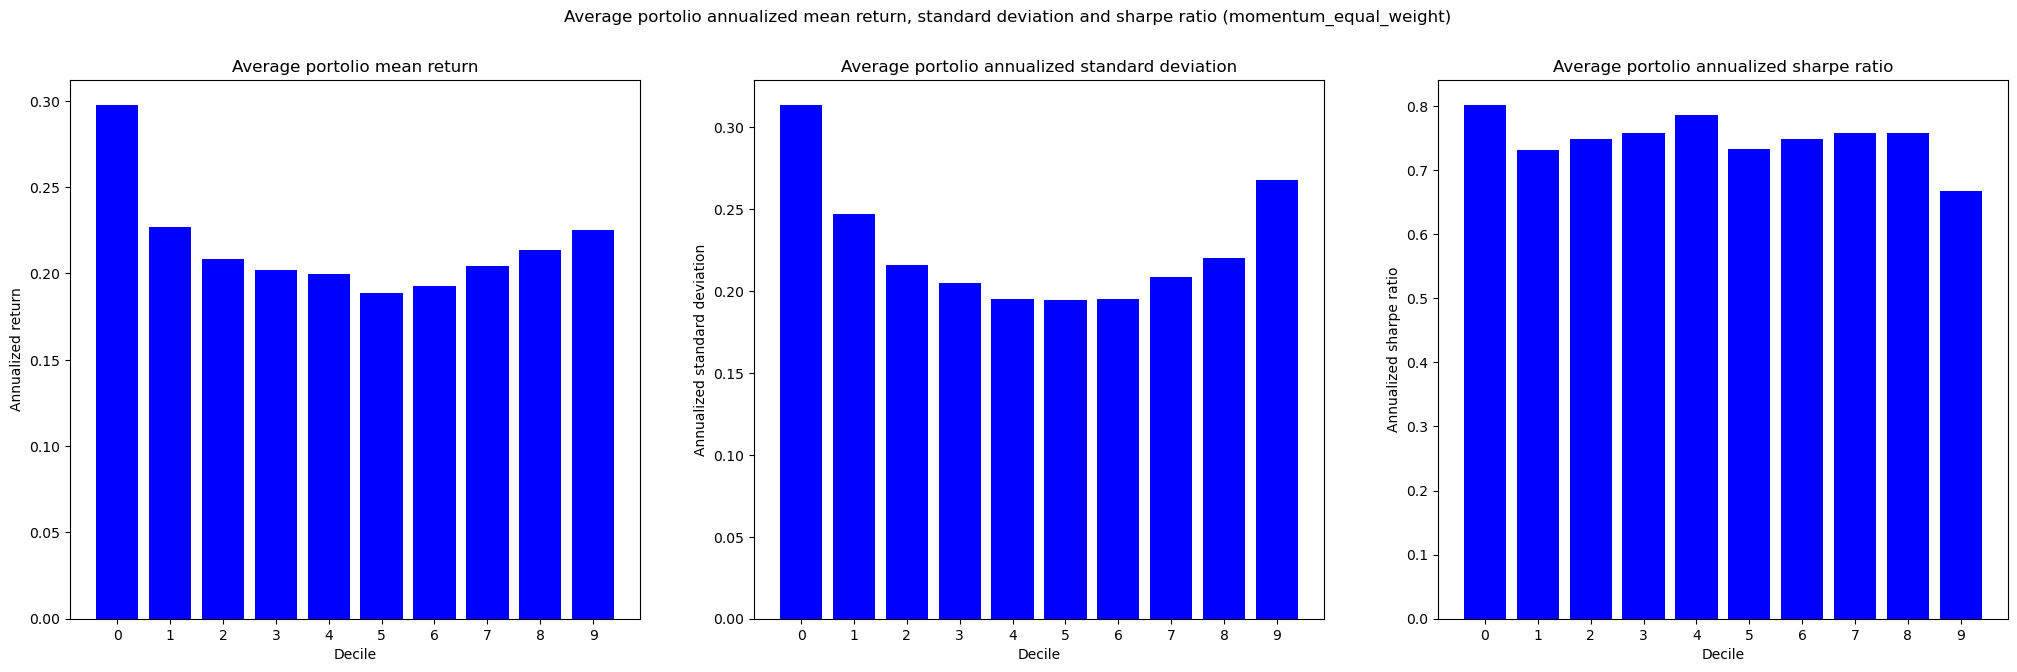

In [104]:
# Plot the mean, std and sharpe ratio for the momentum decile portfolios
plot_mean_std_sr(
    data=data_mom,
    EW = True,
    EW_decile_col='decile_mom',
    EW_return_col='EW_monthly_return',
    VW = False, 
    question = '4a',
    plot_name= 'momentum_equal_weight', 
    show = True
)

### Value weighted portfolios

In [109]:
# Add company market capitalization
data_mom['MktCap'] = np.abs(data_mom.prc) * data_mom.shrout

# Compute the total market capitaliztion for each decile, each month
data_mom["MktCap_sum"] = data_mom.groupby(["date", "decile_mom"])["MktCap"].transform("sum")

# Create weight of the stock to the decile portofolio, for each month
data_mom["VW_monthly_weight"] = data_mom["MktCap"] / data_mom["MktCap_sum"]

# Compute each stock's monthly return in the VW portoflio, for each month, decile
data_mom["VW_monthly_return"] = data_mom["ret"] * data_mom["VW_monthly_weight"]

# Clean the dataframe and delete useless columns: MktCap_sum
data_mom = data_mom.drop(columns=["MktCap_sum"])

display(data_mom) # to get an overview of the dataframe

,permno,date,ret,shrout,prc,siccd,tmytm,vwretd,Rm_e,R_e,beta,roll_ret,decile_mom,EW_monthly_return,MktCap,VW_monthly_weight,VW_monthly_return
203368,19721,1966-09-30,-0.022556,31095.0,16.2500,4131,0.004307,-0.006958,-0.011265,-0.026863,0.684664,-0.103639,0.0,-0.014799,5.052938e+05,0.836856,-1.887613e-02
376415,25099,1966-09-30,-0.007042,5589.0,17.6250,4924,0.004307,-0.006958,-0.011265,-0.011349,1.200862,-0.028422,0.0,-0.014799,9.850612e+04,0.163144,-1.148858e-03
204319,19406,1966-09-30,-0.196347,11941.0,22.0000,2834,0.004307,-0.006958,-0.011265,-0.200654,0.780953,0.056150,1.0,-0.196347,2.627020e+05,1.000000,-1.963470e-01
311848,24643,1966-09-30,-0.038917,21423.0,71.0000,3353,0.004307,-0.006958,-0.011265,-0.043224,0.548634,0.063537,2.0,-0.038917,1.521033e+06,1.000000,-3.891700e-02
74800,13063,1966-09-30,-0.117391,12581.0,25.3750,5311,0.004307,-0.006958,-0.011265,-0.121698,0.643434,0.068437,3.0,-0.012954,3.192429e+05,0.067764,-7.954869e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377943,91575,2023-11-30,0.157974,28268.0,123.6600,7359,0.004465,0.092057,0.087592,0.153509,0.419406,0.438574,9.0,0.069402,3.495621e+06,0.001845,2.915116e-04
1385743,92245,2023-11-30,0.155880,156058.0,14.4900,7359,0.004465,0.092057,0.087592,0.151415,0.419406,0.460055,9.0,0.069402,2.261280e+06,0.001194,1.860762e-04
1390487,92571,2023-11-30,-0.306250,107531.0,0.2442,1311,0.004465,0.092057,0.087592,-0.310715,0.419406,3.450273,9.0,0.069402,2.625907e+04,0.000014,-4.245232e-06
1396451,93016,2023-11-30,0.226681,32952.0,0.1131,2834,0.004465,0.092057,0.087592,0.222216,0.496033,0.546611,9.0,0.069402,3.726871e+03,0.000002,4.459698e-07


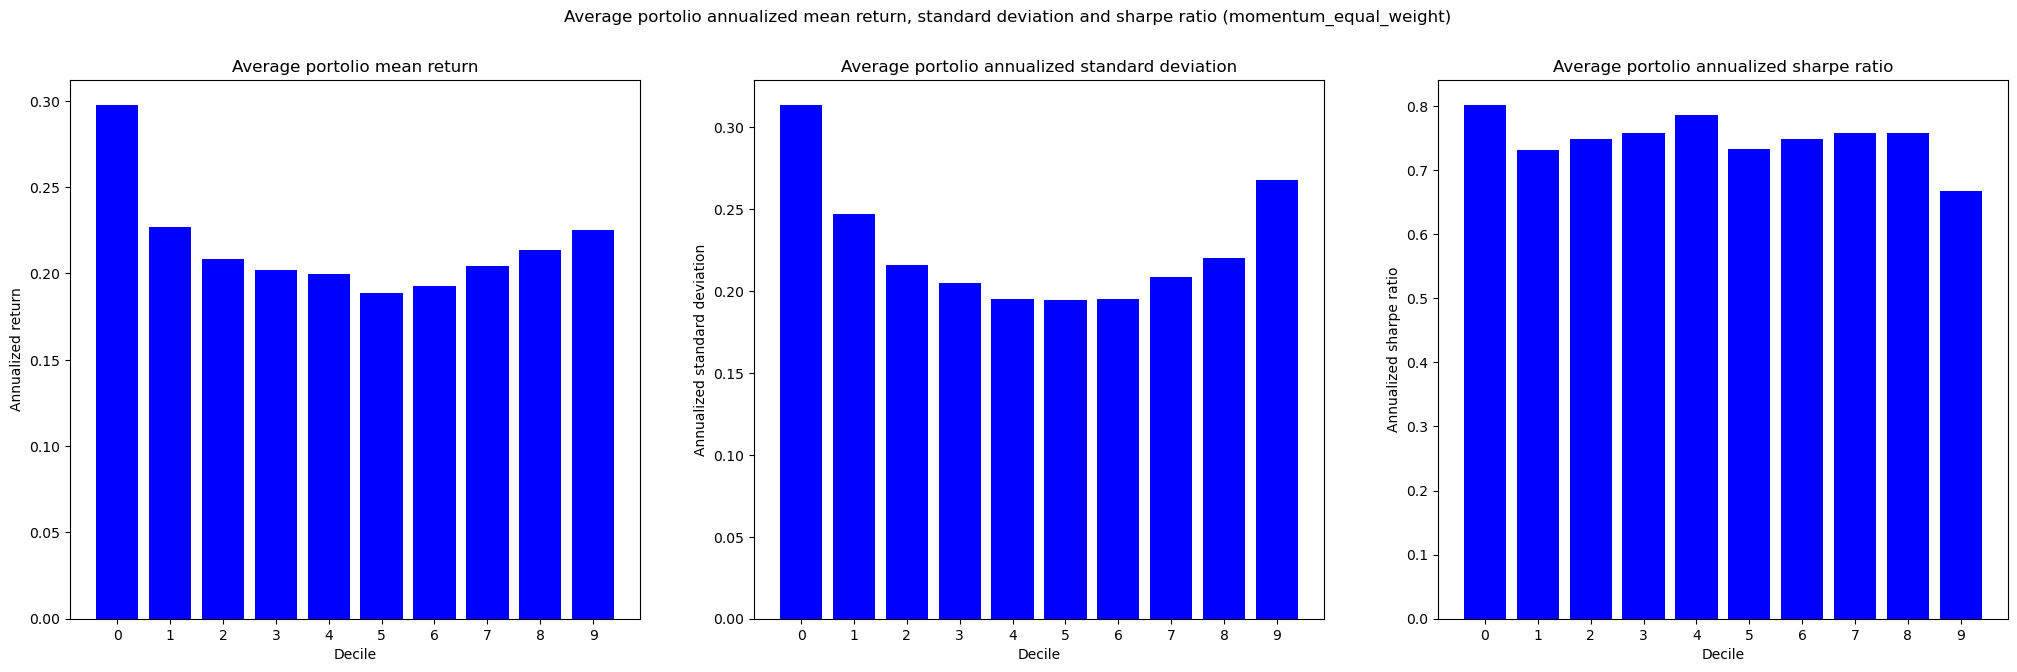

KeyError: 'decile_mom'

In [111]:
# Plot the mean, std and sharpe ratio for the momentum decile EW portfolios
plot_mean_std_sr(
    data=data_mom,
    EW = True,
    EW_decile_col='decile_mom',
    EW_return_col='EW_monthly_return',
    VW = False, 
    question = '4a',
    plot_name= 'momentum_equal_weight', 
    show = True
)

# Plot the mean, std and sharpe ratio for the momentum decile VW portfolios
plot_mean_std_sr(
    data=data_mom,
    EW = False,
    VW = True, 
    VW_decile_col='decile_mom',
    VW_return_col='VW_monthly_return',
    question = '4a',
    plot_name= 'momentum_value_weight', 
    show = True
)